In [1]:
import json 
import os.path
from simulation import Simulation
from simulation.ComplexModeSimulation import ComplexModeSimulation
from model.MassExitTransaction import MassExitTransaction
import matplotlib.pyplot as plt

PROBLEMATIC_INTERVALS = [[1516728783, 1516729440], [1515943500, 1515944160]]

FIRST_BLOCK_HEIGHT_DURING_CONGESTION = 498084 
FIRST_BLOCK_NO_CONGESTION = 716644

MEMPOOL_DIR_DURING_CONGESTION = "../mempool-during-congestion"
MEMPOOL_DIR_NO_CONGESTION = "../mempool-no-congestion"

# Edges crossed by the Max-Cut (LWMC), computed with the weighted imbalanced-max-cut Greedy procedure, 
# with data obtained on May 5, 2022

MAX_CUT_SIZE = 58531 
MAX_CUT_CAPACITY = 2464.37 # Weighted [BTCs]

AVERAGE_LND_CLOSING_CHANNEL_DELAY = 529

# We read the JSON file containing blocks data (height, number of transactions)

blocks_file = open(f"../blocks/blocks.json", mode = 'r')
blocks_data_content = blocks_file.read()
blocks_data = json.loads(blocks_data_content)

# We read the file containing mempool historical data

FIRST_BLOCK_HEIGHT = FIRST_BLOCK_HEIGHT_DURING_CONGESTION
MEMPOOL_DIR = MEMPOOL_DIR_DURING_CONGESTION

# FIRST_BLOCK_HEIGHT = FIRST_BLOCK_NO_CONGESTION
# MEMPOOL_DIR = MEMPOOL_DIR_NO_CONGESTION

i = 1
mempool_data_json_string = ''

while os.path.exists(f"{MEMPOOL_DIR}/{i}_mempool"):
    mempool_data_file = open(f"{MEMPOOL_DIR}/{i}_mempool", mode = 'r')
    mempool_data_content = mempool_data_file.read()
    
    # We replace call() from file content (it is used for the website to load the JSONP)
    mempool_data_content = mempool_data_content[5 : len(mempool_data_content) - 2]
    
    # I remove the first and the last square brackets, then I will add them again at the end before parsing the JSON,
    # in order to obtain a single merged json of all the mempool data
    mempool_data_content = mempool_data_content[1:]
    mempool_data_content = mempool_data_content[:-1]

    mempool_data_content += ','

    mempool_data_json_string += mempool_data_content
    mempool_data_file.close()

    i += 1

mempool_data_json_string = mempool_data_json_string[:-1]
mempool_data_json_string = f"[{mempool_data_json_string}]"

# Parsing JSON file

mempool_data = json.loads(mempool_data_json_string) 

In [2]:
def buildTransactions(num_attacked_channels, fee_index_attacker, initial_tx_with_same_fee_attacker, isDynamic):
    transactions = []
    attackerTx = MassExitTransaction(isAttacker=True, num=num_attacked_channels, isDynamic=False)
    attackerTx.feeIndex = fee_index_attacker
    attackerTx.txWithSameFee = initial_tx_with_same_fee_attacker
    transactions.append(attackerTx)
    for _ in range(num_attacked_channels):
        tx = MassExitTransaction(isAttacker=False, num=1, isDynamic=isDynamic)
        transactions.append(tx)
    
    return transactions  

def runSimulation(sim, transactions, num_attacked_channels, to_self_delay):
    late_penalty_transactions = 0
    confirmedAllAttackerTxLogged = False
    honestIndex = 1
    sim.submitTransaction(transactions[0]) # we submit attacker txs
    last_num_attacker_txs = transactions[0].num
        
    print("[INFO] Starting simulation...")
    
    while sim.hasSnapshots():
        sim.run()
        remainingAttackerTxs = transactions[0].num
        
        if remainingAttackerTxs == 0 and not confirmedAllAttackerTxLogged:
            print(f"[INFO] All attacker transactions mined at block #{sim.blocksCounter}")
            confirmedAllAttackerTxLogged = True
        
        num_confirmed_attacker_txs = last_num_attacker_txs - remainingAttackerTxs
        newHonestIndex = honestIndex + num_confirmed_attacker_txs

        while honestIndex < newHonestIndex:
            honestTx = transactions[honestIndex]
            honestTx.submitted = True
            txsWithNumGreaterThanOne = [0] * len(Simulation.fee_ranges)
            txsWithNumGreaterThanOne[transactions[0].feeIndex] = transactions[0].num
            # with respect to the previous version of the simulation, the main thing that slightly changes results is the fee computation
            honest_fee_index, honest_fee = sim.getAverageFee(txsWithNumGreaterThanOne) # average or median ?
            honestTx.feeIndex = honest_fee_index
            honestTx.currentFee = honest_fee
            honestTx.txWithSameFee = sim.getTxWithSameFee(honest_fee_index)
            honestTx.attackerTxConfirmedBlockNumber = sim.blocksCounter
            honestIndex += 1
            sim.submitTransaction(honestTx)
        
            
        if sim.getConfirmedTxCount() == (2 * num_attacked_channels):
            print(f"[INFO] All transactions confirmed at block #{sim.blocksCounter}")
            
            for tx in transactions:
                if (not tx.isAttacker and tx.confirmedBlockNumber - tx.attackerTxConfirmedBlockNumber) > to_self_delay: 
                    late_penalty_transactions += 1
            print(f"[INFO] {late_penalty_transactions} late penalty transactions")        
            return late_penalty_transactions

        lastHonestTx = transactions[num_attacked_channels]
        if lastHonestTx.submitted and (sim.blocksCounter - lastHonestTx._attackerTxConfirmedBlockNumber) > to_self_delay:
            print(f"[INFO] {to_self_delay} blocks have passed since the last honest tx was submitted at block #{sim.blocksCounter}, ending simulation")
            
            for tx in transactions:
                n = tx.confirmedBlockNumber if tx.confirmed else sim.blocksCounter
                if not tx.isAttacker and n - tx.attackerTxConfirmedBlockNumber> to_self_delay: 
                    late_penalty_transactions += 1
            print(f"[INFO] {late_penalty_transactions} late penalty transactions")        
            return late_penalty_transactions

        last_num_attacker_txs = remainingAttackerTxs
        
    print(f"[WARN] Could not finish the simulation because all the time window has passed")
    return None

to_self_delay: 100 blocks
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7459
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7560, ending simulation
[INFO] 58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7429
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7530, ending simulation
[INFO] 58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7367
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7468, ending simulation
[INFO] 58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined at block #7130
[INFO] 100 blocks have passed since the last honest tx was submitted at block #7231, ending simulation
[INFO] 58531 late penalty transactions
[INFO] Starting simulation...
[INFO] All attacker transactions mined a

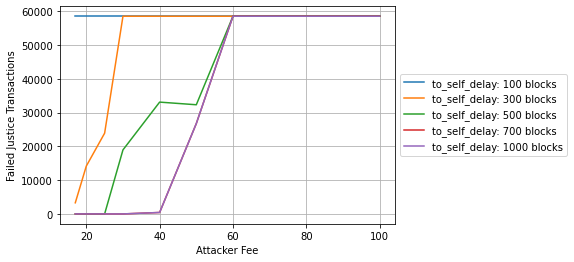

In [3]:
ln_delays = [100, 300, 500, 700, 1000]
labels = []

fig, ax = plt.subplots()
ax.grid(True)

for ln_delay in ln_delays:
    print(f"to_self_delay: {ln_delay} blocks")
    y = []
    x = []

    i = 12
    fee_ranges2 = [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 17, 20, 25, 30, 40, 50, 60, 70, 80, 100 ]
    while(i < len(fee_ranges2)):
        sim = ComplexModeSimulation(mempoolData=mempool_data, blocksData=blocks_data, isDynamic=False, firstBlockHeightOfSimulation=FIRST_BLOCK_HEIGHT, problematicIntervals=PROBLEMATIC_INTERVALS, step=-1, beta=-1)
        transactions = buildTransactions(MAX_CUT_SIZE, i, (sim.getFirstSnapshot())[1][i], False)
        n = runSimulation(sim, transactions, MAX_CUT_SIZE, ln_delay)
        y.append(n)
        x.append(fee_ranges2[i])
        i += 1
    
    plt.plot(x, y)   
    labels.append(f"to_self_delay: {ln_delay} blocks") 

plt.xlabel('Attacker Fee') 
plt.ylabel(f'Failed Justice Transactions')
plt.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()